In [3]:
# a foray into digital removal of lipofuscin through sparse decomposition.
# original code by brianl@alleninstitute.org

import sklearn.decomposition as skd
import numpy as np
import matplotlib.pyplot as plt
import time
import tifffile as tf
import os

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#home machine
img_sample = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_example.tif')

In [4]:
#home machine, background adjusted
img_sample = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_subtracted.tif')

In [ ]:
#home machine, channel-by-channel subtraction 
img_sample = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_corrected.tif')

In [ ]:
#work machine
img_sample = tf.imread('C:/Users/john.villanueva/Downloads/4-color_MIP_example.tif')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


original shape: (2048, 2048, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


new shape: (500, 500, 4)


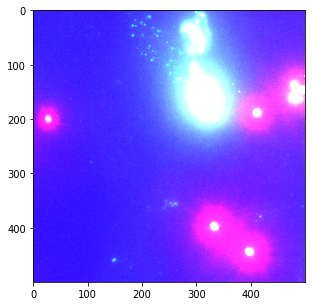

In [5]:
#import sample image
#this particular sample contains four channels:
#488, 568, 647, and DAPI/468

#reshaping axes so that channels are in third dimension
img_sample = np.transpose(img_sample,axes=[1,2,0])

#slicing a smaller subsample
img_sub = img_sample[750:1250,300:800,:].astype(np.float)

print("original shape: {}".format(img_sample.shape))
plt.figure(figsize=(20,20))
plt.imshow(img_sample.astype(np.int))

print("new shape: {}".format(img_sub.shape))
plt.figure(figsize=(5,5))
plt.imshow(img_sub.astype(np.int))

In [6]:
#viewing the image by channels

channel488 = img_sub[:, :, 0] - np.min(img_sub[:, :, 0])
channel568 = img_sub[:, :, 1]# - 129
channel647 = img_sub[:, :, 2] - np.min(img_sub[:, :, 2])
channel750 = img_sub[:, :, 3] - np.min(img_sub[:, :, 3]) 

plt.figure(figsize=(30,30))

plt.subplot(2,2,1)
plt.imshow(channel488)
plt.title("488")

plt.subplot(2,2,2)
plt.imshow(channel568)
plt.title("568")

plt.subplot(2,2,3)
plt.imshow(channel647)
plt.title("647")

plt.subplot(2,2,4)
plt.imshow(channel750)
plt.title("750")


print('488 minimum intensity: {}'.format(np.min(channel488)))
print('568 minimum intensity: {}'.format(np.min(channel568)))
print('647 minimum intensity: {}'.format(np.min(channel647)))
print('750 minimum intensity: {}'.format(np.min(channel750)))

488 minimum intensity: 0.0
568 minimum intensity: 0.0
647 minimum intensity: 0.0
750 minimum intensity: 0.0


In [7]:
#flattening images for linear fit
#taking every other pixel for speed of calculations

subset488 = channel488[::2, ::2].flatten()
subset568 = channel568[::2, ::2].flatten()
subset647 = channel647[::2, ::2].flatten()
subset750 = channel750[::2, ::2].flatten()

In [ ]:
subset568.shape

In [8]:
#histogram shows that there are pixels well beyond the 4000 range
#these signals are most likely due to beads, so they must be separated
#to prevent skewing of calculations

_filter = np.logical_and(subset568 > 750, subset488 < 3750)
beads = 4000

t_sub0 = subset488[_filter]
t_sub1 = subset568[_filter]
t_sub2 = subset647[_filter]

In [9]:
# first, perform least squares fit to attain coefficients of a polynomial function
# create an n-th degree, 1D polynomial to express the fit of data
# enter range of datapoints into function to generate line of best fit
# then plot against datapoints to see if there is mixing involved
# to isolate pixels with lipofuscin signal;

plt.figure(figsize=(20,20))

_568to647 = np.polyfit(t_sub1.astype(float),  t_sub2.astype(float), 1)
plt.plot(t_sub1, t_sub2, '.', label='568/647')
fx_568to647 = np.poly1d(_568to647)
a = np.arange(200,np.max(subset568),10);
plt.plot(a, fx_568to647(a), label='568 to 647')

_568to488 = np.polyfit(t_sub1.astype(float),  t_sub0.astype(float), 1)
plt.plot(t_sub1, t_sub0, '.', label='568/488')
fx_568to488 = np.poly1d(_568to488)
b = np.arange(200,np.max(t_sub1),10);
plt.plot(b, fx_568to488(b), label='568 to 488')


plt.legend(loc='upper left')
plt.ylim(top=6000, bottom=0)
plt.xlim(left=0, right=6000)
plt.show()
print(_568to647)
print(_568to488)

[  0.80636357 259.62436927]
[ 0.45416743 33.79210389]


In [10]:
#bead signals per channel
b0 = subset488[subset488 > beads]
b1 = subset568[subset488 > beads]
b2 = subset647[subset488 > beads]

In [12]:
#same approach, but for signals in the range of bead intensity

plt.figure(figsize=(20,20))

beads_488to568 = np.polyfit(b0.astype(float),  b1.astype(float), 1)
plt.plot(b0, b1, '.', label='488, 568 bead signal')
fx_beads_488to568 = np.poly1d(beads_488to568)
a = np.arange(4000, np.max(b0), 1000);
plt.plot(a, fx_beads_488to568(a), label='488 to 568, bead signal')

beads_488to647 = np.polyfit(b0.astype(float),  b2.astype(float), 1)
plt.plot(b0, b2, '.', label='488, 647 bead signal')
fx_beads_488to647 = np.poly1d(beads_488to647)
a = np.arange(4000,np.max(b0),1000);
plt.plot(a, fx_beads_488to647(a), label='488 to 647, bead signal')

plt.legend(loc='upper left')
plt.show()
print(beads_488to568)
print(beads_488to647)

[ 0.06050128 27.01048338]
[3.17817945e-02 2.70502052e+02]


In [13]:
'''
    Row vectors that represent the coefficients of a 1D, n-th degree polynomial are built from the LSE
    fits calculated previously, which are then used to build a polynomial matrix.

'''

# based on these linear fits 
# we estimate some values for the mixing matrix
#lipofuscin
c0 = [_568to488[0], 1, _568to647[0],  0]

# for single-band emission filters, there is essentially zero crosstalk.
c1 = [ 1., 0., 0., 0.] # Alexa 488  
c2 = [ 0., 1., 0., 0.] # Alexa 568
c3 = [ 0., 0., 1., 0.] # Alexa 647
c4 = [ 0., 0., 0., 1.] # Alexa 750

# bead signal
cB = [1., beads_488to568[0], beads_488to647[0],  0.] 

# and once we normalize the channel weights for each label, we have our dictionary

c0 = c0/np.sqrt(np.dot(c0,c0))
c1 = c1/np.sqrt(np.dot(c1,c1))
c2 = c2/np.sqrt(np.dot(c2,c2))
c3 = c3/np.sqrt(np.dot(c3,c3))
c4 = c4/np.sqrt(np.dot(c4,c4))
cB = cB/np.sqrt(np.dot(cB,cB))


testDict = np.array([
c0,
c1,
c2,
c3,
c4,
cB])
print(testDict)
print(testDict.shape)

[[0.33332635 0.73392835 0.59181308 0.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.9976729  0.06036049 0.03170784 0.        ]]
(6, 4)


(250000, 4)
1e-05
Wed May  5 19:47:45 2021
Wed May  5 19:48:39 2021
(500, 500, 6)
1e-05


5e-06
Wed May  5 19:48:40 2021
Wed May  5 19:49:29 2021
(500, 500, 6)
5e-06


1e-06
Wed May  5 19:49:30 2021
Wed May  5 19:50:20 2021
(500, 500, 6)
1e-06


5e-07
Wed May  5 19:50:21 2021
Wed May  5 19:51:10 2021
(500, 500, 6)
5e-07


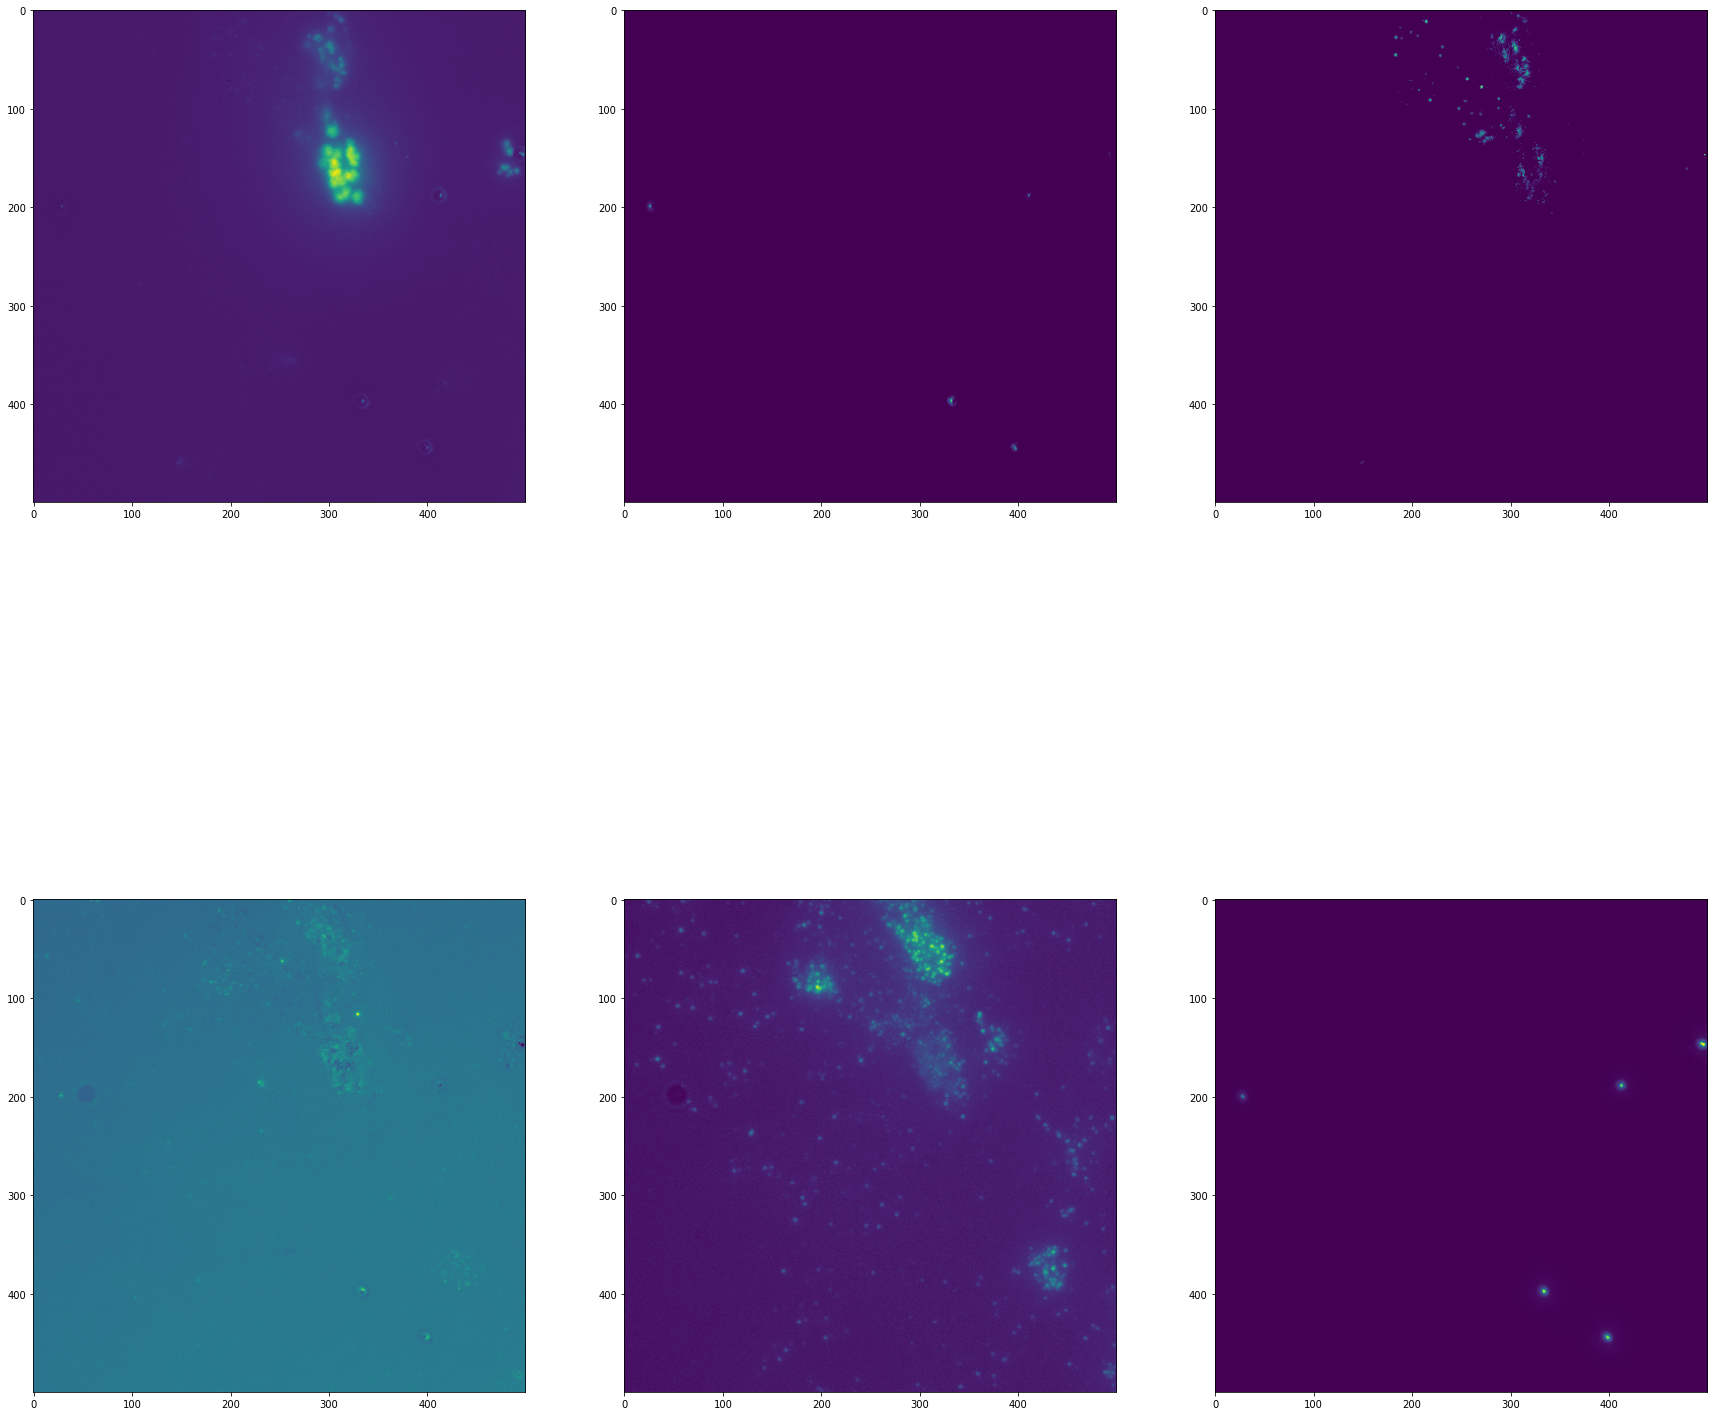

1e-07
Wed May  5 19:51:11 2021
Wed May  5 19:51:59 2021
(500, 500, 6)
1e-07


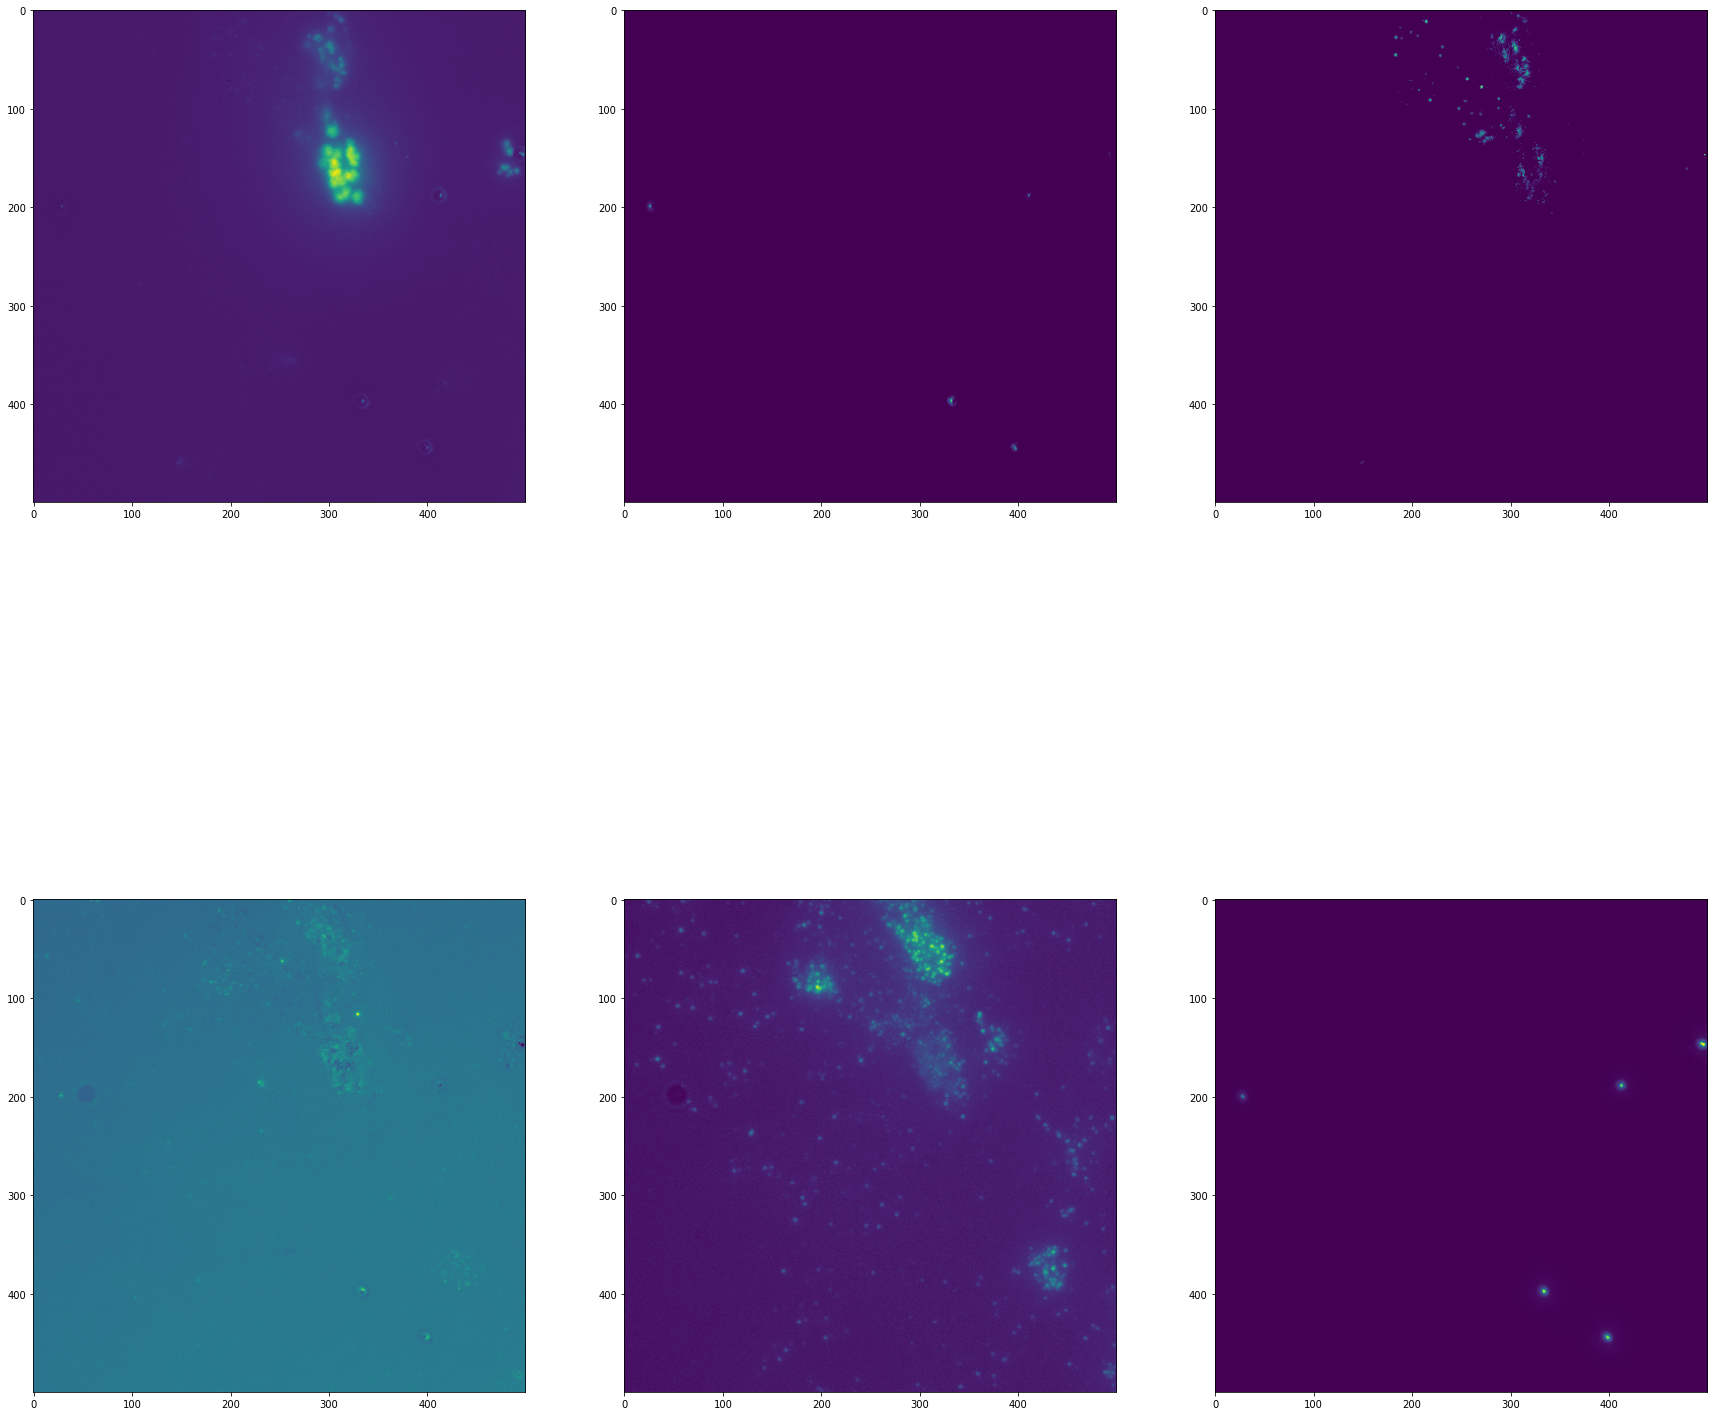

In [19]:
alphaList =[1e-5, 5e-6, 1e-6, 5e-7, 1e-7]

inputArray = img_sub.reshape(img_sub.shape[0]*img_sub.shape[1], img_sub.shape[2])
print(inputArray.shape)

for ii, alpha in enumerate(alphaList): 
    print(alpha)
    print(time.ctime())
    
    mySparseCoder = skd.SparseCoder(testDict, transform_algorithm='lasso_lars', transform_alpha = alpha, n_jobs = 16) 
    # the fit_transform method for this class doesn't do any fitting because
    # the transform is based on the fixed input dictionary
    
    transformedData = mySparseCoder.fit_transform(inputArray)
    tData = transformedData.reshape(img_sub.shape[0], img_sub.shape[1], testDict.shape[0])
    tData = tData-tData.min()
    
    print(time.ctime())
    print(tData.shape)
    print(alpha)
    
    plt.figure(figsize=(30,30))
    
    for i in np.arange(0,testDict.shape[0]):
        
        plt.subplot(2, 3, i+1)
        plt.imshow(tData[:, :, i])
    
    plt.show()
    

    #  this off the shelf seems to work reasonably well for all these alpha values, but it is prohibitively slow for our application 
    # (3 min to do 3 colors and 3.2M pixels) is not fast enough when we routinely collect data with ~4 OoM more pixels.
    # I'm sure this method can be optimized for speed, but I also suspect there are better ways to do this!

In [ ]:
#isolating small regions of lipofuscin and beads to check intensity ratios

lf1 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_lf1_corrected.tif')
lf2 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_lf2_corrected.tif')
lf3 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_lf3_corrected.tif')

bead1 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_b1.tif')
bead2 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_b2.tif')
bead3 = tf.imread('C:/Users/John/Documents/Work/AI_work/lipofuscin/4-color_MIP_b3.tif')



In [ ]:
lf_subs = [lf1, lf2, lf3]
bead_subs = [bead1, bead2, bead3]

for i in lf_subs:
    print(i.shape)
    
for b in bead_subs:
    print(b.shape)

In [ ]:
#since these image crops are in their original shape
#shape[0] corresponds to the channels
#in this case, we will take sums from each channel
#and divide them by the sum of 568 intensities

for i, image in enumerate(lf_subs):
    _568 = np.sum(image[1, :, :])
    
    print('Ratios of lf{}'.format(i+1))
    for j in range(0, 4):
        print(np.sum(image[j, :, :])/_568)
    print('\n')

In [ ]:
for i, image in enumerate(bead_subs):
    _568 = np.sum(image[1, :, :])
    
    print('Ratios of bead{}'.format(i+1))
    for j in range(0, 4):
        print(np.sum(image[j, :, :])/_568)
    print('\n')

In [ ]:
for i, image in enumerate(lf_subs):   
    print('lf{}'.format(i+1))
    print(np.mean(np.mean(image, axis=1), axis=1))
    print('\n')

In [ ]:
subsetlf_488 = []
subsetlf_568 = []
subsetlf_647 = []

for i in lf_subs:
    subsetlf_488.append(i[0, :, :].flatten())
    subsetlf_568.append(i[1, :, :].flatten())
    subsetlf_647.append(i[2, :, :].flatten())
    
subsetlf_488 = np.concatenate(subsetlf_488)
subsetlf_568 = np.concatenate(subsetlf_568)
subsetlf_647 = np.concatenate(subsetlf_647)

In [ ]:
print(subsetlf_488)
print(subsetlf_568)
print(subsetlf_647)

np.sum(subsetlf_647)/np.sum(subsetlf_568)

In [ ]:
#plotting lipofuscin signals against fit plot

plt.figure(figsize=(20,20))

n_568to647 = np.polyfit(t_sub1.astype(float),  t_sub2.astype(float), 1)
plt.plot(t_sub1, t_sub2, '.', label='x(568), y(647)')
plt.plot(subsetlf_568, subsetlf_647, 'X', label='568/647 lipofuscin')
fx_568to647 = np.poly1d(_568to647)
a = np.arange(200,np.max(subset568),10);
plt.plot(a, fx_568to647(a), label='568 to 647')

n_568to488 = np.polyfit(t_sub1.astype(float),  t_sub0.astype(float), 1)
plt.plot(t_sub1, t_sub0, '.', label='568/488')
plt.plot(subsetlf_568, subsetlf_488, 'X', label='568/488 lipofuscin')
fx_568to488 = np.poly1d(_568to488)
b = np.arange(200,np.max(t_sub1),10);
plt.plot(b, fx_568to488(b), label='568 to 488')

n_488to568 = np.polyfit(t_sub0.astype(float), t_sub1.astype(float), 1)
plt.plot(t_sub0, t_sub1,'.', label='488/568')
plt.plot(subsetlf_488, subsetlf_568, 'X', label='488/568 lipofuscin')
fx_488to568 = np.poly1d(_488to568)
c = np.arange(200,np.max(t_sub1),10);
plt.plot(c, fx_488to568(c), label='488 to 568')

n_488to647 = np.polyfit(t_sub0.astype(float),  t_sub2.astype(float), 1)
plt.plot(t_sub0,t_sub2, '.', label='488/647')
plt.plot(subsetlf_488, subsetlf_647, 'X', label='488/647 lipofuscin')
fx_488to647 = np.poly1d(_488to647)
d = np.arange(400,np.max(t_sub1),10);
plt.plot(d, fx_488to647(d), label='488 to 647')


plt.legend(loc='upper left')
plt.ylim(top=6000, bottom=0)
plt.xlim(left=0, right=6000)
plt.show()
print(n_568to647)
print(n_568to488)
print(n_488to568)
print(n_488to647)




In [ ]:
x = np.asarray([0, 1, 2])
y = np.asarray([0,.5, 1])

plt.figure(figsize=(10,10))
samplefit = np.polyfit(x.astype(float),  y.astype(float), 1)
plt.plot(x, y, '.')
fx_sample = np.poly1d(samplefit)
s = np.arange(0,2,0.1);
plt.plot(s, fx_sample(s))

print(samplefit)
print(np.sum(y)/np.sum(x))